## https://flopy.readthedocs.io/en/3.4.1/Notebooks/mf_tutorial01.html

In [22]:
# ## Getting Started
#
# If FloPy has been properly installed, then it can be imported as follows:
from pathlib import Path
from tempfile import TemporaryDirectory

In [4]:
import numpy as np
import flopy

In [4]:
temp_dir = TemporaryDirectory()
workspace = Path(temp_dir.name)
name = "tutorial01_mf"
mf = flopy.modflow.Modflow(name, exe_name="mf2005", model_ws=workspace)

In [5]:
Lx = 1000.0
Ly = 1000.0
ztop = 0.0
zbot = -50.0
nlay = 1
nrow = 10
ncol = 10
delr = Lx / ncol
delc = Ly / nrow
delv = (ztop - zbot) / nlay
botm = np.linspace(ztop, zbot, nlay + 1)

In [6]:
dis = flopy.modflow.ModflowDis(
    mf, nlay, nrow, ncol, delr=delr, delc=delc, top=ztop, botm=botm[1:]
)

In [7]:
ibound = np.ones((nlay, nrow, ncol), dtype=np.int32)
ibound[:, :, 0] = -1
ibound[:, :, -1] = -1
strt = np.ones((nlay, nrow, ncol), dtype=np.float32)
strt[:, :, 0] = 10.0
strt[:, :, -1] = 0.0
bas = flopy.modflow.ModflowBas(mf, ibound=ibound, strt=strt)

In [8]:
lpf = flopy.modflow.ModflowLpf(mf, hk=10.0, vka=10.0, ipakcb=53)

In [9]:
spd = {(0, 0): ["print head", "print budget", "save head", "save budget"]}
oc = flopy.modflow.ModflowOc(mf, stress_period_data=spd, compact=True)

In [10]:
pcg = flopy.modflow.ModflowPcg(mf)

In [11]:
mf.write_input()

In [12]:
success, buff = mf.run_model()
assert success, "MODFLOW did not terminate normally."

FloPy is using the following executable to run the model: ..\..\..\..\..\gross.DESKTOP-AIRQM2M\anaconda3\envs\pyclass\Scripts\mf2005.exe

                                  MODFLOW-2005     
    U.S. GEOLOGICAL SURVEY MODULAR FINITE-DIFFERENCE GROUND-WATER FLOW MODEL
                             Version 1.12.00 2/3/2017                        

 Using NAME file: tutorial01_mf.nam 
 Run start date and time (yyyy/mm/dd hh:mm:ss): 2024/12/15 13:47:40

 Solving:  Stress period:     1    Time step:     1    Ground-Water Flow Eqn.
 Run end date and time (yyyy/mm/dd hh:mm:ss): 2024/12/15 13:47:40
 Elapsed run time:  0.038 Seconds

  Normal termination of simulation


In [13]:
import matplotlib.pyplot as plt
import flopy.utils.binaryfile as bf

In [14]:
hds = bf.HeadFile(Path(workspace) / f"{name}.hds")
head = hds.get_data(totim=1.0)

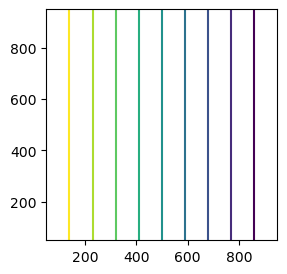

In [20]:
extent = (delr / 2.0, Lx - delr / 2.0, Ly - delc / 2.0, delc / 2.0)
fig = plt.figure(figsize=(3, 3))
ax = fig.add_subplot(1, 1, 1, aspect="equal")
ax.contour(head[0, :, :], levels=np.arange(1, 10, 1), extent=extent)

In [16]:
# Extract the heads
hds = bf.HeadFile(Path(workspace) / f"{name}.hds")
times = hds.get_times()
head = hds.get_data(totim=times[-1])

In [17]:
cbb = bf.CellBudgetFile(Path(workspace) / f"{name}.cbc")
kstpkper_list = cbb.get_kstpkper()
frf = cbb.get_data(text="FLOW RIGHT FACE", totim=times[-1])[0]
fff = cbb.get_data(text="FLOW FRONT FACE", totim=times[-1])[0]
qx, qy, qz = flopy.utils.postprocessing.get_specific_discharge(
    (frf, fff, None), mf, head
)

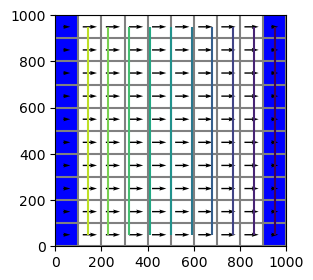

In [19]:
fig = plt.figure(figsize=(3, 3))
ax = fig.add_subplot(1, 1, 1, aspect="equal")
modelmap = flopy.plot.PlotMapView(model=mf, layer=0, ax=ax)
qm = modelmap.plot_ibound()
lc = modelmap.plot_grid()
cs = modelmap.contour_array(head, levels=np.linspace(0, 10, 11))
quiver = modelmap.plot_vector(qx, qy)

In [21]:
try:
    temp_dir.cleanup()
except:
    # prevent windows permission error
    pass